# 과제

In [1]:
# 4_02_HumanActivity (201page~)    4_08_(252page~)_산탄데르(~259page까지)     제출하기

## HumanActivity

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])

# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])


전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [23]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [24]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                         if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [25]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [26]:
print('## 학습 피처 데이터셋 info()')
print(X_train.info())

## 학습 피처 데이터셋 info()
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


In [27]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:
 {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': 156, 'splitter': 'best'}


In [29]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.2min finished


GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [30]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성. 
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]


,param_max_depth,mean_test_score
0,6,0.850791
1,8,0.851069
2,10,0.851209
3,12,0.844135
4,16,0.851344
5,20,0.850800
6,24,0.849440


In [31]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8558
max_depth = 8 정확도: 0.8707
max_depth = 10 정확도: 0.8673
max_depth = 12 정확도: 0.8646
max_depth = 16 정확도: 0.8575
max_depth = 20 정확도: 0.8548
max_depth = 24 정확도: 0.8548


In [32]:
params = {
    'max_depth' : [ 8 , 12, 16 ,20], 
    'min_samples_split' : [16,24],
}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  1.4min finished


GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [33]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


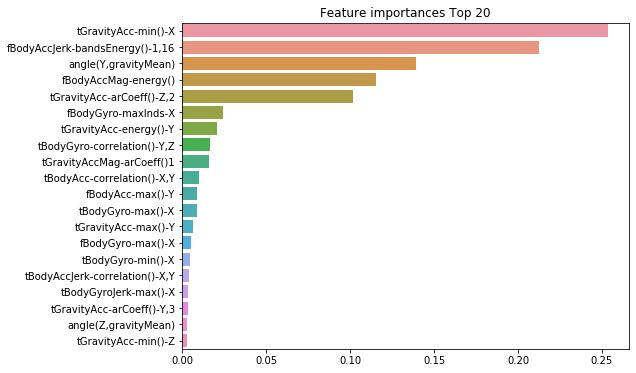

In [34]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

## 4.08 캐글 산탄데르 고객 만족 예측

In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv("./data/train_santander.csv",encoding='latin-1')
print('dataset shape:', cust_df.shape)
cust_df.head(3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [37]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [38]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt = cust_df[cust_df['TARGET'] == 1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt / total_cnt)))

0    73012
1     3008
Name: TARGET, dtype: int64
unsatisfied 비율은 0.04


In [39]:
cust_df.describe( )

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [40]:
# var3 피처 값 대체 및 ID 피처 드롭
cust_df['var3'].replace(-999999,2, inplace=True)
cust_df.drop('ID',axis=1 , inplace=True)

# 피처 세트와 레이블 세트분리. 레이블 컬럼은 DataFrame의 맨 마지막에 위치해 컬럼 위치 -1로 분리
X_features = cust_df.iloc[:, :-1]
y_labels = cust_df.iloc[:, -1]
print('피처 데이터 shape:{0}'.format(X_features.shape))


피처 데이터 shape:(76020, 369)


In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape:{0}, 테스트 세트 Shape:{1}'.format(X_train.shape , X_test.shape))

print(' 학습 세트 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape:(60816, 369), 테스트 세트 Shape:(15204, 369)
 학습 세트 레이블 값 분포 비율
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [42]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정. 
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행. 
xgb_clf.fit(X_train, y_train, early_stopping_rounds=100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1],average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))



[0]	validation_0-auc:0.82005	validation_1-auc:0.81157
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.83400	validation_1-auc:0.82452
[2]	validation_0-auc:0.83870	validation_1-auc:0.82746
[3]	validation_0-auc:0.84419	validation_1-auc:0.82922
[4]	validation_0-auc:0.84783	validation_1-auc:0.83298
[5]	validation_0-auc:0.85125	validation_1-auc:0.83500
[6]	validation_0-auc:0.85501	validation_1-auc:0.83653
[7]	validation_0-auc:0.85830	validation_1-auc:0.83782
[8]	validation_0-auc:0.86143	validation_1-auc:0.83802
[9]	validation_0-auc:0.86452	validation_1-auc:0.83914
[10]	validation_0-auc:0.86717	validation_1-auc:0.83954
[11]	validation_0-auc:0.87013	validation_1-auc:0.83983
[12]	validation_0-auc:0.87369	validation_1-auc:0.84033
[13]	validation_0-auc:0.87620	validation_1-auc:0.84054
[14]	validation_0-auc:0.87799	validation_1-auc:0.84135
[15]	validation_0-auc:0.880

In [43]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params = {'max_depth':[5, 7] , 'min_child_weight':[1,3] ,'colsample_bytree':[0.5, 0.75] }

# cv는 3으로 지정 
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric="auc",
           eval_set=[(X_train, y_train), (X_test, y_test)])

print('GridSearchCV 최적 파라미터:',gridcv.best_params_) 

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.79161	validation_1-auc:0.79321
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.81865	validation_1-auc:0.81375
[2]	validation_0-auc:0.82586	validation_1-auc:0.81846
[3]	validation_0-auc:0.82789	validation_1-auc:0.82226
[4]	validation_0-auc:0.83249	validation_1-auc:0.82677
[5]	validation_0-auc:0.83477	validation_1-auc:0.83225
[6]	validation_0-auc:0.83340	validation_1-auc:0.82654
[7]	validation_0-auc:0.84223	validation_1-auc:0.83486
[8]	validation_0-auc:0.84586	validation_1-auc:0.83682
[9]	validation_0-auc:0.84557	validation_1-auc:0.83472
[10]	validation_0-auc:0.84423	validation_1-auc:0.83181
[11]	validation_0-auc:0.84428	validation_1-auc:0.82920
[12]	validation_0-auc:0.85176	validation_1-auc:0.83433
[13]	validation_0-auc:0.85540	validation_1-auc:0.83565
[14]	validation_0-auc:0.85719	validation_1-auc:0.83696
[15]	validation_0-auc:0.8584

[43]	validation_0-auc:0.87525	validation_1-auc:0.84022
[44]	validation_0-auc:0.87595	validation_1-auc:0.83967
[45]	validation_0-auc:0.87630	validation_1-auc:0.84004
[46]	validation_0-auc:0.87700	validation_1-auc:0.83966
[47]	validation_0-auc:0.87743	validation_1-auc:0.83963
[48]	validation_0-auc:0.87770	validation_1-auc:0.83931
[49]	validation_0-auc:0.87782	validation_1-auc:0.83925
[50]	validation_0-auc:0.87827	validation_1-auc:0.83935
[51]	validation_0-auc:0.87862	validation_1-auc:0.83920
[52]	validation_0-auc:0.87951	validation_1-auc:0.83895
[53]	validation_0-auc:0.88027	validation_1-auc:0.83876
[54]	validation_0-auc:0.88118	validation_1-auc:0.83840
[55]	validation_0-auc:0.88128	validation_1-auc:0.83834
[56]	validation_0-auc:0.88146	validation_1-auc:0.83873
[57]	validation_0-auc:0.88158	validation_1-auc:0.83860
[58]	validation_0-auc:0.88183	validation_1-auc:0.83810
[59]	validation_0-auc:0.88192	validation_1-auc:0.83774
[60]	validation_0-auc:0.88215	validation_1-auc:0.83723
Stopping. 

[24]	validation_0-auc:0.86453	validation_1-auc:0.84460
[25]	validation_0-auc:0.86537	validation_1-auc:0.84480
[26]	validation_0-auc:0.86586	validation_1-auc:0.84441
[27]	validation_0-auc:0.86656	validation_1-auc:0.84401
[28]	validation_0-auc:0.86698	validation_1-auc:0.84422
[29]	validation_0-auc:0.86770	validation_1-auc:0.84385
[30]	validation_0-auc:0.86778	validation_1-auc:0.84407
[31]	validation_0-auc:0.86804	validation_1-auc:0.84395
[32]	validation_0-auc:0.86828	validation_1-auc:0.84381
[33]	validation_0-auc:0.86865	validation_1-auc:0.84417
[34]	validation_0-auc:0.86902	validation_1-auc:0.84385
[35]	validation_0-auc:0.86959	validation_1-auc:0.84369
[36]	validation_0-auc:0.87019	validation_1-auc:0.84297
[37]	validation_0-auc:0.87050	validation_1-auc:0.84278
[38]	validation_0-auc:0.87180	validation_1-auc:0.84286
[39]	validation_0-auc:0.87270	validation_1-auc:0.84224
[40]	validation_0-auc:0.87288	validation_1-auc:0.84197
[41]	validation_0-auc:0.87293	validation_1-auc:0.84175
[42]	valid

[22]	validation_0-auc:0.88633	validation_1-auc:0.83706
[23]	validation_0-auc:0.88770	validation_1-auc:0.83714
[24]	validation_0-auc:0.88866	validation_1-auc:0.83742
[25]	validation_0-auc:0.88907	validation_1-auc:0.83753
[26]	validation_0-auc:0.89067	validation_1-auc:0.83634
[27]	validation_0-auc:0.89161	validation_1-auc:0.83565
[28]	validation_0-auc:0.89214	validation_1-auc:0.83460
[29]	validation_0-auc:0.89341	validation_1-auc:0.83413
[30]	validation_0-auc:0.89378	validation_1-auc:0.83373
[31]	validation_0-auc:0.89393	validation_1-auc:0.83396
[32]	validation_0-auc:0.89409	validation_1-auc:0.83435
[33]	validation_0-auc:0.89414	validation_1-auc:0.83412
[34]	validation_0-auc:0.89433	validation_1-auc:0.83386
[35]	validation_0-auc:0.89511	validation_1-auc:0.83338
[36]	validation_0-auc:0.89554	validation_1-auc:0.83232
[37]	validation_0-auc:0.89588	validation_1-auc:0.83223
[38]	validation_0-auc:0.89608	validation_1-auc:0.83222
[39]	validation_0-auc:0.89640	validation_1-auc:0.83187
[40]	valid

[30]	validation_0-auc:0.88457	validation_1-auc:0.84080
[31]	validation_0-auc:0.88542	validation_1-auc:0.84070
[32]	validation_0-auc:0.88561	validation_1-auc:0.84055
[33]	validation_0-auc:0.88609	validation_1-auc:0.84024
[34]	validation_0-auc:0.88632	validation_1-auc:0.83977
[35]	validation_0-auc:0.88638	validation_1-auc:0.83959
[36]	validation_0-auc:0.88644	validation_1-auc:0.83935
[37]	validation_0-auc:0.88730	validation_1-auc:0.83898
[38]	validation_0-auc:0.88803	validation_1-auc:0.83814
[39]	validation_0-auc:0.88817	validation_1-auc:0.83806
[40]	validation_0-auc:0.88815	validation_1-auc:0.83811
[41]	validation_0-auc:0.88838	validation_1-auc:0.83807
[42]	validation_0-auc:0.88881	validation_1-auc:0.83753
[43]	validation_0-auc:0.88902	validation_1-auc:0.83781
[44]	validation_0-auc:0.88912	validation_1-auc:0.83779
Stopping. Best iteration:
[14]	validation_0-auc:0.87102	validation_1-auc:0.84520

[0]	validation_0-auc:0.81007	validation_1-auc:0.80693
Multiple eval metrics have been passed:

[31]	validation_0-auc:0.87189	validation_1-auc:0.84252
[32]	validation_0-auc:0.87276	validation_1-auc:0.84147
[33]	validation_0-auc:0.87303	validation_1-auc:0.84149
[34]	validation_0-auc:0.87350	validation_1-auc:0.84118
[35]	validation_0-auc:0.87370	validation_1-auc:0.84115
[36]	validation_0-auc:0.87408	validation_1-auc:0.84113
[37]	validation_0-auc:0.87477	validation_1-auc:0.84038
[38]	validation_0-auc:0.87530	validation_1-auc:0.84009
[39]	validation_0-auc:0.87541	validation_1-auc:0.83988
[40]	validation_0-auc:0.87556	validation_1-auc:0.83984
[41]	validation_0-auc:0.87580	validation_1-auc:0.83991
[42]	validation_0-auc:0.87631	validation_1-auc:0.83942
[43]	validation_0-auc:0.87667	validation_1-auc:0.83926
[44]	validation_0-auc:0.87715	validation_1-auc:0.83916
[45]	validation_0-auc:0.87765	validation_1-auc:0.83868
Stopping. Best iteration:
[15]	validation_0-auc:0.85990	validation_1-auc:0.84361

[0]	validation_0-auc:0.81105	validation_1-auc:0.80637
Multiple eval metrics have been passed:

[24]	validation_0-auc:0.86688	validation_1-auc:0.84082
[25]	validation_0-auc:0.86778	validation_1-auc:0.84074
[26]	validation_0-auc:0.86849	validation_1-auc:0.84076
[27]	validation_0-auc:0.86909	validation_1-auc:0.84096
[28]	validation_0-auc:0.86930	validation_1-auc:0.84113
[29]	validation_0-auc:0.86973	validation_1-auc:0.84187
[30]	validation_0-auc:0.87070	validation_1-auc:0.84167
[31]	validation_0-auc:0.87108	validation_1-auc:0.84174
[32]	validation_0-auc:0.87124	validation_1-auc:0.84166
[33]	validation_0-auc:0.87154	validation_1-auc:0.84142
[34]	validation_0-auc:0.87216	validation_1-auc:0.84153
[35]	validation_0-auc:0.87288	validation_1-auc:0.84147
[36]	validation_0-auc:0.87324	validation_1-auc:0.84136
[37]	validation_0-auc:0.87343	validation_1-auc:0.84116
[38]	validation_0-auc:0.87351	validation_1-auc:0.84114
[39]	validation_0-auc:0.87406	validation_1-auc:0.84087
[40]	validation_0-auc:0.87415	validation_1-auc:0.84088
[41]	validation_0-auc:0.87540	validation_1-auc:0.84065
[42]	valid

[26]	validation_0-auc:0.89397	validation_1-auc:0.83459
[27]	validation_0-auc:0.89434	validation_1-auc:0.83497
[28]	validation_0-auc:0.89490	validation_1-auc:0.83437
[29]	validation_0-auc:0.89493	validation_1-auc:0.83446
[30]	validation_0-auc:0.89559	validation_1-auc:0.83426
[31]	validation_0-auc:0.89565	validation_1-auc:0.83405
[32]	validation_0-auc:0.89653	validation_1-auc:0.83320
[33]	validation_0-auc:0.89680	validation_1-auc:0.83358
[34]	validation_0-auc:0.89762	validation_1-auc:0.83320
[35]	validation_0-auc:0.89782	validation_1-auc:0.83337
[36]	validation_0-auc:0.89811	validation_1-auc:0.83330
[37]	validation_0-auc:0.89813	validation_1-auc:0.83297
[38]	validation_0-auc:0.89838	validation_1-auc:0.83265
[39]	validation_0-auc:0.89870	validation_1-auc:0.83239
[40]	validation_0-auc:0.89877	validation_1-auc:0.83215
[41]	validation_0-auc:0.89897	validation_1-auc:0.83207
[42]	validation_0-auc:0.89904	validation_1-auc:0.83192
[43]	validation_0-auc:0.89918	validation_1-auc:0.83183
[44]	valid

[32]	validation_0-auc:0.88796	validation_1-auc:0.83611
[33]	validation_0-auc:0.88928	validation_1-auc:0.83562
[34]	validation_0-auc:0.89022	validation_1-auc:0.83498
[35]	validation_0-auc:0.89040	validation_1-auc:0.83515
[36]	validation_0-auc:0.89105	validation_1-auc:0.83420
[37]	validation_0-auc:0.89119	validation_1-auc:0.83435
[38]	validation_0-auc:0.89161	validation_1-auc:0.83405
[39]	validation_0-auc:0.89254	validation_1-auc:0.83376
[40]	validation_0-auc:0.89268	validation_1-auc:0.83387
[41]	validation_0-auc:0.89275	validation_1-auc:0.83334
[42]	validation_0-auc:0.89324	validation_1-auc:0.83343
[43]	validation_0-auc:0.89320	validation_1-auc:0.83370
[44]	validation_0-auc:0.89401	validation_1-auc:0.83323
[45]	validation_0-auc:0.89457	validation_1-auc:0.83295
[46]	validation_0-auc:0.89506	validation_1-auc:0.83239
Stopping. Best iteration:
[16]	validation_0-auc:0.87739	validation_1-auc:0.83927

[0]	validation_0-auc:0.80839	validation_1-auc:0.80987
Multiple eval metrics have been passed:

In [4]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize=(10,8))
plot_importance(xgb_clf, ax=ax , max_num_features=20,height=0.4)

ImportError: cannot import name 'plot_importance' from 'xgboost' (unknown location)